In [1]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"qiiiey","key":"fa3ae371ac16a6d7c212d99b03ce0e55"}'}

In [3]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json into the right folder
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

print("Kaggle API configured!")


Kaggle API configured!


In [4]:
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification


Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
License(s): CC0-1.0
  0% 0.00/64.4M [00:00<?, ?B/s]
100% 64.4M/64.4M [00:00<00:00, 1.71GB/s]


In [5]:
import zipfile

zip_path = "cats-and-dogs-image-classification.zip"
extract_path = "cats_dogs_data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: cats_dogs_data


In [6]:
import os

for root, dirs, files in os.walk("cats_dogs_data"):
    print(root, "->", len(files), "files")
    if len(files) > 0:
        print("Sample files:", files[:5])
    print("-" * 60)


cats_dogs_data -> 0 files
------------------------------------------------------------
cats_dogs_data/test -> 0 files
------------------------------------------------------------
cats_dogs_data/test/dogs -> 70 files
Sample files: ['dog_196.jpg', 'dog_141.jpg', 'dog_28.jpg', 'dog_237.jpg', 'dog_313.jpg']
------------------------------------------------------------
cats_dogs_data/test/cats -> 70 files
Sample files: ['cat_564.jpg', 'cat_341.jpg', 'cat_464.jpg', 'cat_525.jpg', 'cat_88.jpg']
------------------------------------------------------------
cats_dogs_data/train -> 0 files
------------------------------------------------------------
cats_dogs_data/train/dogs -> 278 files
Sample files: ['dog_11.jpg', 'dog_317.jpg', 'dog_207.jpg', 'dog_552.jpg', 'dog_8.jpg']
------------------------------------------------------------
cats_dogs_data/train/cats -> 279 files
Sample files: ['cat_221.jpg', 'cat_453.jpg', 'cat_285.jpg', 'cat_248.jpg', 'cat_149.jpg']
--------------------------------------

In [7]:
# Import reqimport tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os


In [16]:
DATASET_PATH = "cats_dogs_data"

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")

IMAGE_SIZE = (224, 224)   # Standard for CNNs (works with transfer learning too)
BATCH_SIZE = 32
SEED = 42


In [17]:
# Load training & validation data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.


In [18]:
# Load test dataset (no split)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 140 files belonging to 2 classes.


In [19]:
# Verify class names
class_names = train_ds.class_names
print("Class Names:", class_names)


Class Names: ['cats', 'dogs']


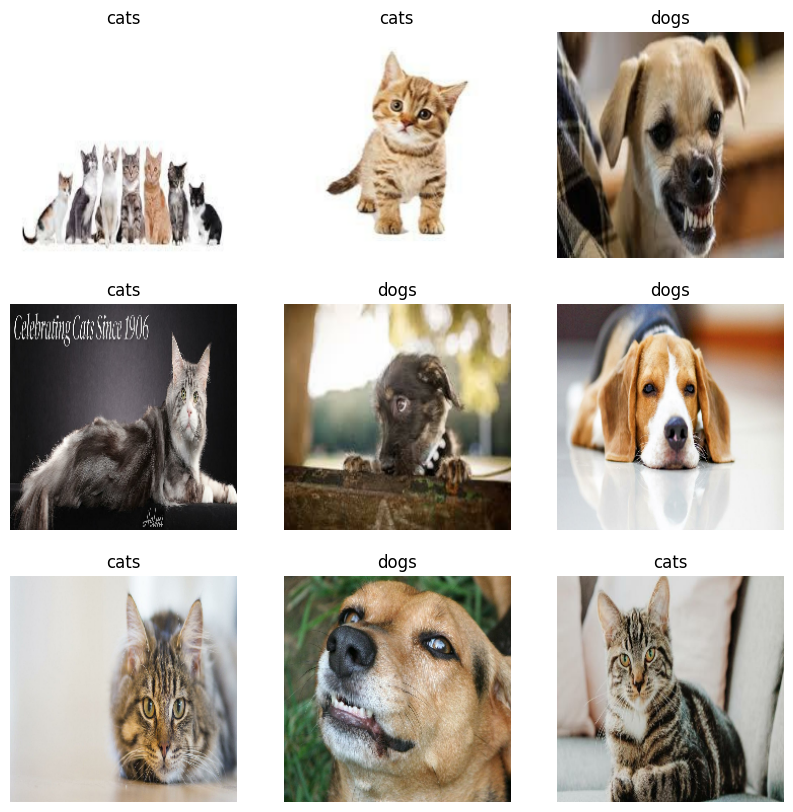

In [20]:
# Visualize sample images (sanity check)
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [21]:
# Data Augmentation (to reduce overfitting)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [23]:
# Normalize pixel values (0–1)
normalization_layer = layers.Rescaling(1./255)


In [24]:
# Apply augmentation & normalization to datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(normalization_layer(x)), y),
    num_parallel_calls=AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE
)

test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE
)


In [25]:
# Optimize pipeline performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


##MODEL TRAINING

In [26]:
# Common imports for training & evaluation
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [27]:
# Utility function: Plot accuracy curves
def plot_accuracy(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [28]:
# Utility function: Confusion Matrix
def plot_confusion_matrix(model, dataset, title):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        preds = (preds > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


In [29]:
# MODEL 1: SIMPLE CUSTOM CNN (Baseline)
model_1 = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_1.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train Model 1
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 532ms/step - accuracy: 0.4905 - loss: 2.9183 - val_accuracy: 0.5045 - val_loss: 0.6981
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6217 - loss: 0.6614 - val_accuracy: 0.5586 - val_loss: 0.7157
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6116 - loss: 0.6460 - val_accuracy: 0.5405 - val_loss: 0.6630
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7808 - loss: 0.5775 - val_accuracy: 0.5946 - val_loss: 0.6421
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8551 - loss: 0.4309 - val_accuracy: 0.5856 - val_loss: 0.7480
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8841 - loss: 0.3412 - val_accuracy: 0.5495 - val_loss: 0.7970
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9389 - loss: 0.2231 - val_accuracy: 0.5946 - val_loss: 0.9871
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9447 - loss: 0.1839 - val_accuracy: 0.5586 -

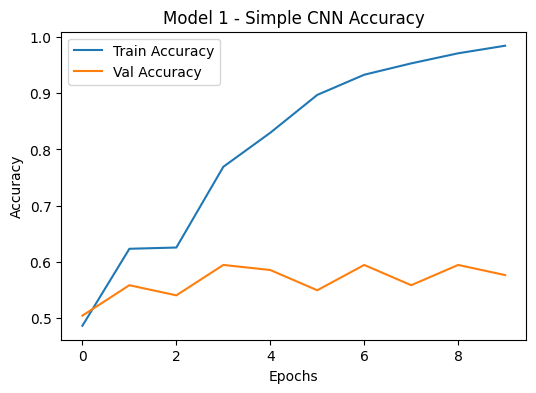

In [31]:
# Accuracy plot (Model 1)
plot_accuracy(history_1, "Model 1 - Simple CNN Accuracy")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


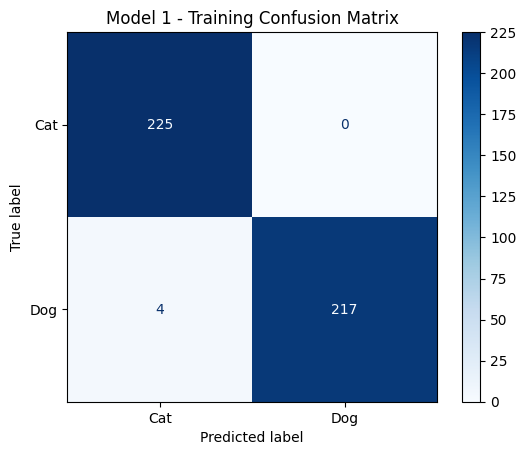

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


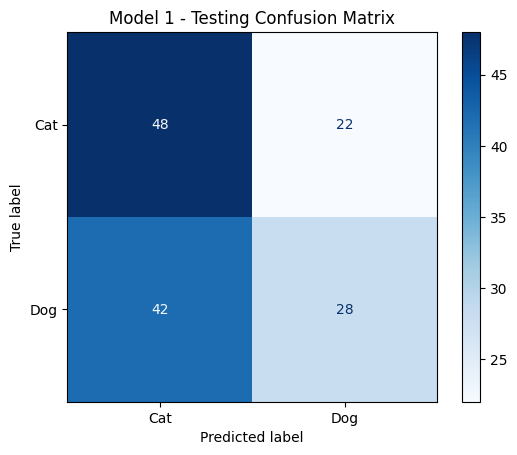

In [32]:
# Confusion Matrices (Model 1)
plot_confusion_matrix(model_1, train_ds, "Model 1 - Training Confusion Matrix")
plot_confusion_matrix(model_1, test_ds, "Model 1 - Testing Confusion Matrix")


In [33]:
# MODEL 2: DEEPER CUSTOM CNN
model_2 = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_2.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train Model 2
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9553 - loss: 0.1032 - val_accuracy: 0.4865 - val_loss: 1.8594
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9537 - loss: 0.1182 - val_accuracy: 0.5495 - val_loss: 2.5020
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9842 - loss: 0.0502 - val_accuracy: 0.5225 - val_loss: 2.0385
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9806 - loss: 0.0547 - val_accuracy: 0.5946 - val_loss: 2.1874
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9870 - loss: 0.0420 - val_accuracy: 0.5676 - val_loss: 2.5742
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9935 - loss: 0.0364 - val_accuracy: 0.5225 - val_loss: 2.5990
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9928 - loss: 0.0242 - val_accuracy: 0.6036 - val_loss: 3.0328
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9822 - loss: 0.0811 - val_accuracy: 0.5405 - v

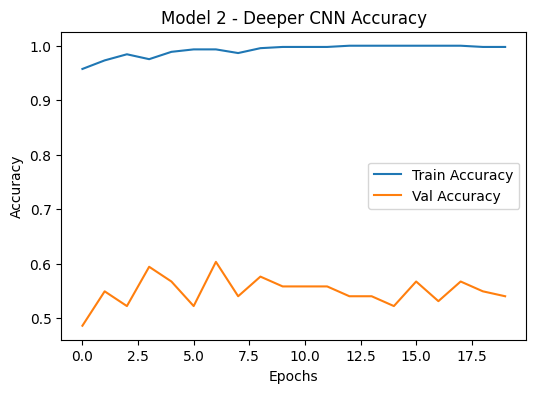

In [38]:
# Accuracy plot (Model 2)
plot_accuracy(history_2, "Model 2 - Deeper CNN Accuracy")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


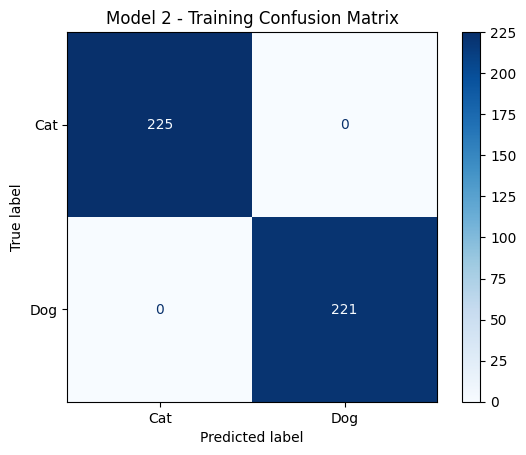

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


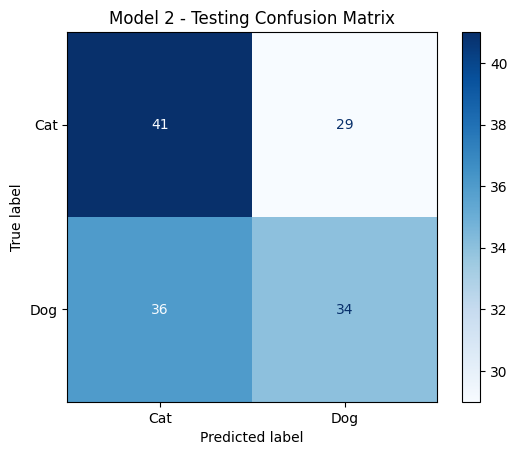

In [39]:
# Confusion Matrices (Model 2)
plot_confusion_matrix(model_2, train_ds, "Model 2 - Training Confusion Matrix")
plot_confusion_matrix(model_2, test_ds, "Model 2 - Testing Confusion Matrix")


In [40]:
# MODEL 3: TRANSFER LEARNING (BEST PRACTICE)

# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [41]:
# Build Model 3
model_3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_3.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [48]:
# train model 3
history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25
)


Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 3.1945e-04 - val_accuracy: 0.9640 - val_loss: 0.1002
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 3.7741e-04 - val_accuracy: 0.9640 - val_loss: 0.1011
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 4.1785e-04 - val_accuracy: 0.9640 - val_loss: 0.1018
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.5989e-04 - val_accuracy: 0.9640 - val_loss: 0.1027
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.3446e-04 - val_accuracy: 0.9640 - val_loss: 0.1030
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 2.8826e-04 - val_accuracy: 0.9640 - val_loss: 0.1035
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 3.0749e-04 - val_accuracy: 0.9640 - val_loss: 0.1043
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 2.754

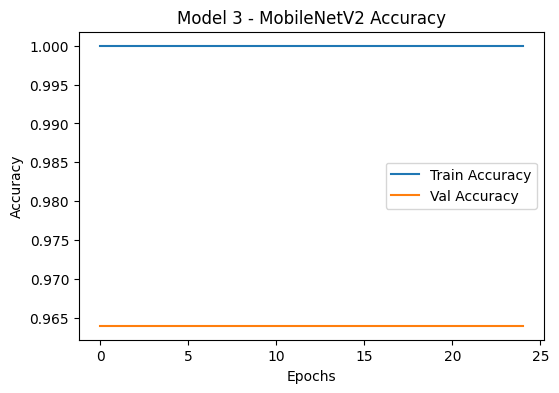

In [49]:
# Accuracy plot (Model 3)
plot_accuracy(history_3, "Model 3 - MobileNetV2 Accuracy")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


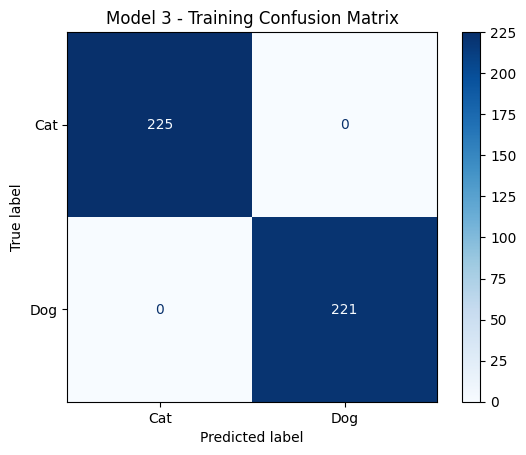

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


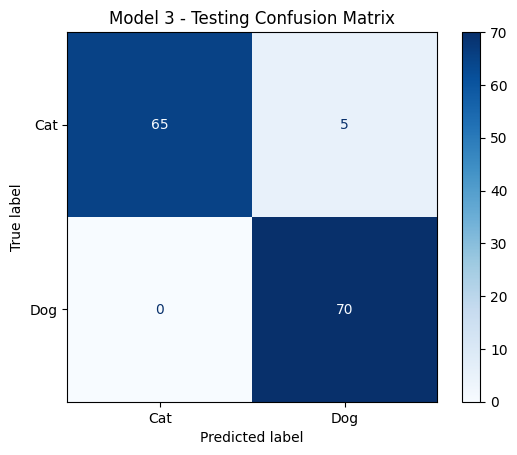

In [50]:
# Confusion Matrices (Model 3)
plot_confusion_matrix(model_3, train_ds, "Model 3 - Training Confusion Matrix")
plot_confusion_matrix(model_3, test_ds, "Model 3 - Testing Confusion Matrix")


In [51]:
# MODEL COMPARISON + EVALUATION + SAVE BEST

# Evaluate all models on Train + Test (accuracy + loss)

def evaluate_model(model, train_ds, test_ds, name="model"):
    train_loss, train_acc = model.evaluate(train_ds, verbose=0)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    return {
        "name": name,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_loss": test_loss,
        "test_acc": test_acc
    }

results = []
results.append(evaluate_model(model_1, train_ds, test_ds, "Model 1 - Simple CNN"))
results.append(evaluate_model(model_2, train_ds, test_ds, "Model 2 - Deeper CNN"))
results.append(evaluate_model(model_3, train_ds, test_ds, "Model 3 - MobileNetV2"))

results


[{'name': 'Model 1 - Simple CNN',
  'train_loss': 0.042129550129175186,
  'train_acc': 0.9910314083099365,
  'test_loss': 2.0909252166748047,
  'test_acc': 0.5428571701049805},
 {'name': 'Model 2 - Deeper CNN',
  'train_loss': 0.0011048634769394994,
  'train_acc': 1.0,
  'test_loss': 4.612717628479004,
  'test_acc': 0.5357142686843872},
 {'name': 'Model 3 - MobileNetV2',
  'train_loss': 0.0001195505537907593,
  'train_acc': 1.0,
  'test_loss': 0.16792456805706024,
  'test_acc': 0.9642857313156128}]

In [52]:
# Display comparison table nicely
import pandas as pd

df_results = pd.DataFrame(results).sort_values(by="test_acc", ascending=False).reset_index(drop=True)
df_results


,name,train_loss,train_acc,test_loss,test_acc
0,Model 3 - MobileNetV2,0.000120,1.000000,0.167925,0.964286
1,Model 1 - Simple CNN,0.042130,0.991031,2.090925,0.542857
2,Model 2 - Deeper CNN,0.001105,1.000000,4.612718,0.535714


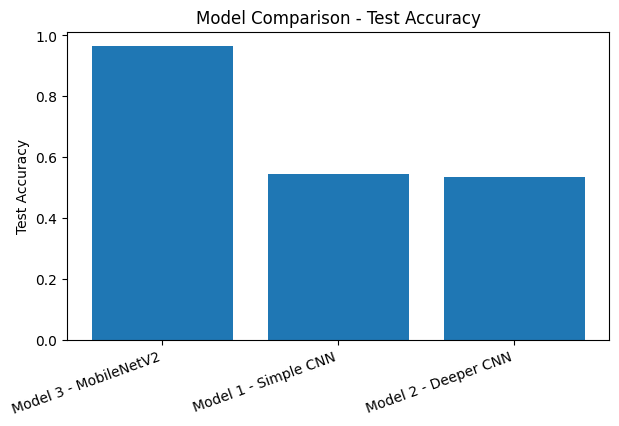

In [53]:
# Plot comparison (Test Accuracy)
plt.figure(figsize=(7,4))
plt.bar(df_results["name"], df_results["test_acc"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Test Accuracy")
plt.show()


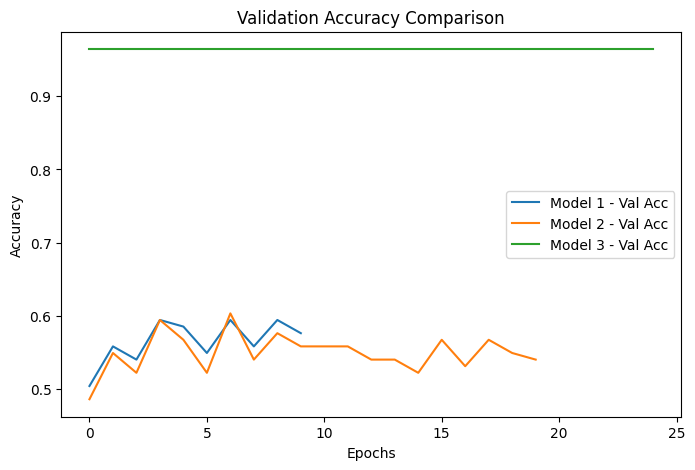

In [54]:
# Plot all training curves in one view (Accuracy)
plt.figure(figsize=(8,5))

plt.plot(history_1.history["val_accuracy"], label="Model 1 - Val Acc")
plt.plot(history_2.history["val_accuracy"], label="Model 2 - Val Acc")
plt.plot(history_3.history["val_accuracy"], label="Model 3 - Val Acc")

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


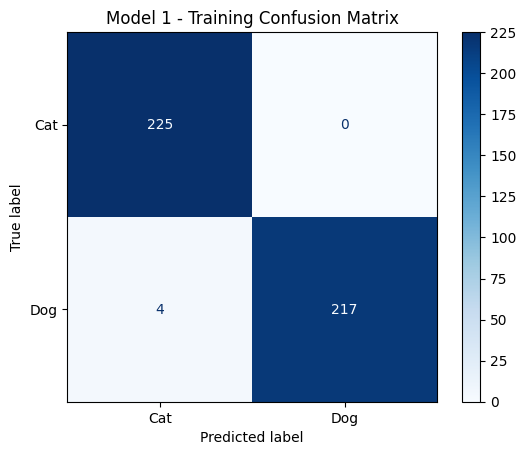

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


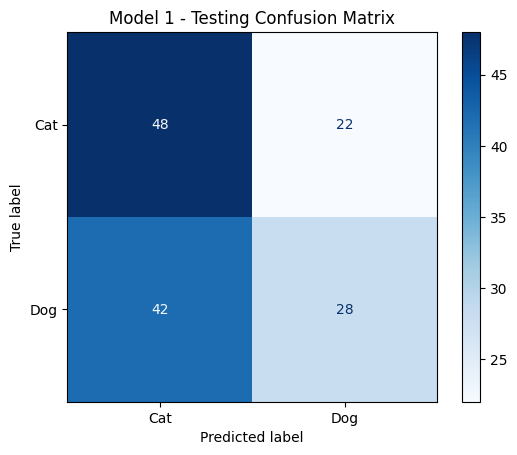

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


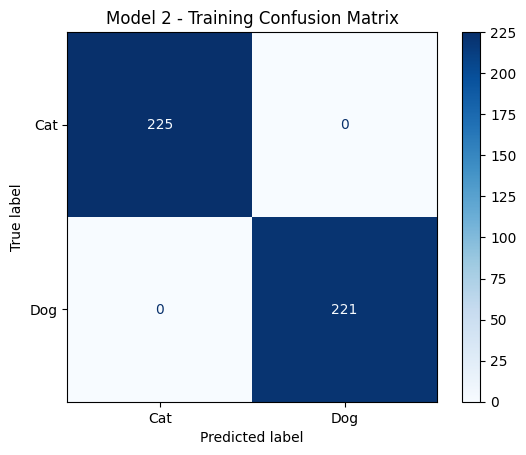

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


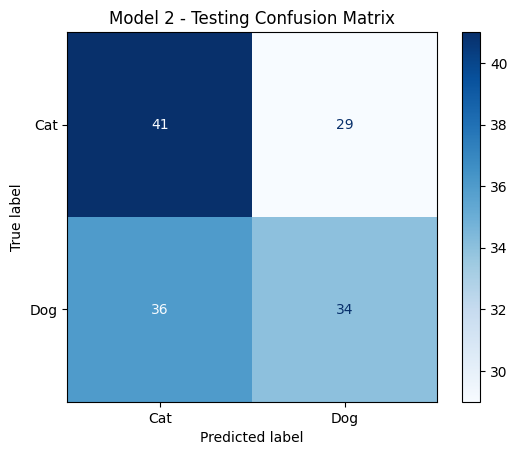

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


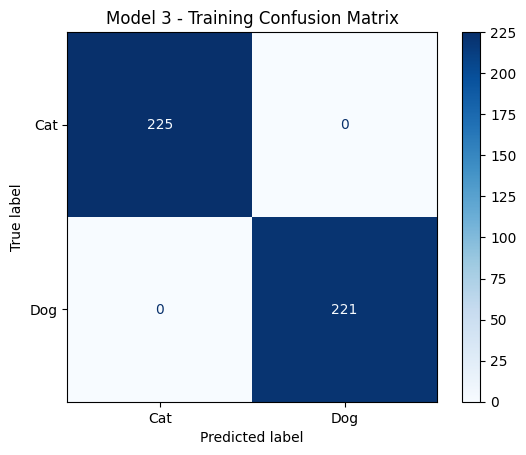

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


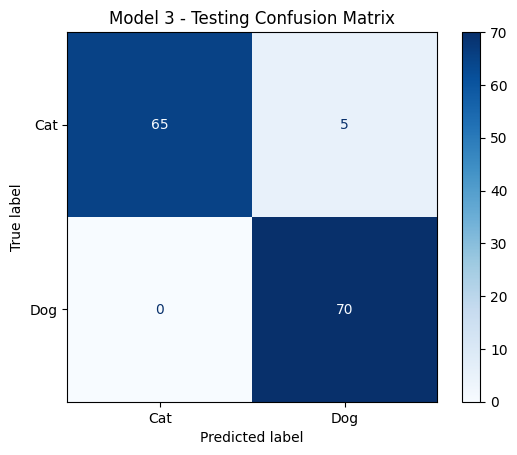

In [55]:
# Confusion Matrices (Train + Test) for all models
# Model 1
plot_confusion_matrix(model_1, train_ds, "Model 1 - Training Confusion Matrix")
plot_confusion_matrix(model_1, test_ds,  "Model 1 - Testing Confusion Matrix")

# Model 2
plot_confusion_matrix(model_2, train_ds, "Model 2 - Training Confusion Matrix")
plot_confusion_matrix(model_2, test_ds,  "Model 2 - Testing Confusion Matrix")

# Model 3
plot_confusion_matrix(model_3, train_ds, "Model 3 - Training Confusion Matrix")
plot_confusion_matrix(model_3, test_ds,  "Model 3 - Testing Confusion Matrix")


In [56]:
# Detailed metrics (Precision / Recall / F1) on TEST set
from sklearn.metrics import classification_report

def get_predictions(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        probs = model.predict(images, verbose=0).flatten()
        preds = (probs >= 0.5).astype(int)
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

for m, name in [(model_1, "Model 1"), (model_2, "Model 2"), (model_3, "Model 3")]:
    y_true, y_pred = get_predictions(m, test_ds)
    print("\n" + "="*60)
    print(name, "- TEST Classification Report")
    print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))



Model 1 - TEST Classification Report
              precision    recall  f1-score   support

         Cat       0.53      0.69      0.60        70
         Dog       0.56      0.40      0.47        70

    accuracy                           0.54       140
   macro avg       0.55      0.54      0.53       140
weighted avg       0.55      0.54      0.53       140


Model 2 - TEST Classification Report
              precision    recall  f1-score   support

         Cat       0.53      0.59      0.56        70
         Dog       0.54      0.49      0.51        70

    accuracy                           0.54       140
   macro avg       0.54      0.54      0.53       140
weighted avg       0.54      0.54      0.53       140


Model 3 - TEST Classification Report
              precision    recall  f1-score   support

         Cat       1.00      0.93      0.96        70
         Dog       0.93      1.00      0.97        70

    accuracy                           0.96       140
   macro avg  

In [57]:
# Select best model automatically (highest test accuracy)
best_row = df_results.iloc[0]
best_name = best_row["name"]

best_model = {
    "Model 1 - Simple CNN": model_1,
    "Model 2 - Deeper CNN": model_2,
    "Model 3 - MobileNetV2": model_3
}[best_name]

print("✅ Best model selected:", best_name)
print("Test Accuracy:", float(best_row["test_acc"]))


✅ Best model selected: Model 3 - MobileNetV2
Test Accuracy: 0.9642857313156128


In [58]:
BEST_MODEL_H5 = "cats_vs_dogs_mobilenetv2.h5"

best_model.save(BEST_MODEL_H5)
print("✅ Best model saved in H5 format:", BEST_MODEL_H5)


✅ Best model saved in H5 format: cats_vs_dogs_mobilenetv2.h5


In [59]:
# Verify model reload works (important sanity check)
loaded_model = tf.keras.models.load_model(BEST_MODEL_H5)

loss, acc = loaded_model.evaluate(test_ds, verbose=0)
print(f"Reloaded Model Test Accuracy: {acc:.4f}")


Reloaded Model Test Accuracy: 0.9643


In [60]:
# Download .h5 model from Colab
from google.colab import files
files.download(BEST_MODEL_H5)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## FINAL INFERENCE PIPELINE

In [61]:
# Inference helper (single image)
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np

CLASS_NAMES = ["Cat", "Dog"]

def predict_single_image(model, img_path, img_size=(224,224)):
    img = keras_image.load_img(img_path, target_size=img_size)
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prob_dog = float(model.predict(img_array, verbose=0)[0][0])
    pred_class = 1 if prob_dog >= 0.5 else 0

    return {
        "prediction": CLASS_NAMES[pred_class],
        "dog_probability": prob_dog,
        "cat_probability": 1 - prob_dog
    }


In [62]:
# Test inference on test images
import glob

test_cat = glob.glob("cats_dogs_data/test/cats/*.jpg")[0]
test_dog = glob.glob("cats_dogs_data/test/dogs/*.jpg")[0]

print("Cat Image Prediction:", predict_single_image(best_model, test_cat))
print("Dog Image Prediction:", predict_single_image(best_model, test_dog))


Cat Image Prediction: {'prediction': 'Cat', 'dog_probability': 3.4484528441680595e-05, 'cat_probability': 0.9999655154715583}
Dog Image Prediction: {'prediction': 'Dog', 'dog_probability': 0.9999090433120728, 'cat_probability': 9.09566879272461e-05}
